# Logistic Regression

为了方便使用，将theta表示为(n,1)的列向量。同时使用batch向量化。用numpy来表示数据。

**导入需要的包**

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# 准备数据

In [137]:
data = pd.read_csv('ex2data1.txt',names=['exam1','exam2','admitted'])
data.info()
print(data.head(n=5))
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
exam1       100 non-null float64
exam2       100 non-null float64
admitted    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB
       exam1      exam2  admitted
0  34.623660  78.024693         0
1  30.286711  43.894998         0
2  35.847409  72.902198         0
3  60.182599  86.308552         1
4  79.032736  75.344376         1


,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


**对数据进行绘制**

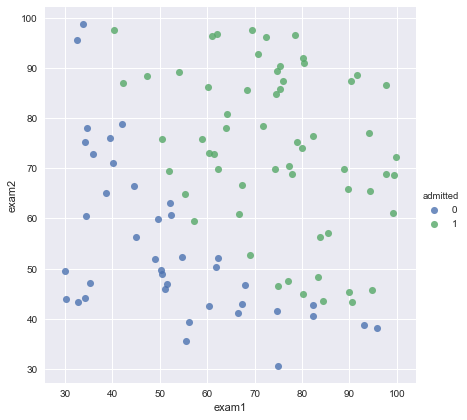

In [129]:
sns.set(context='notebook',style='darkgrid')
sns.lmplot("exam1","exam2",hue="admitted",data=data,size=6,fit_reg=False,scatter_kws={"s":50})
plt.show()

**将数据转换为numpy格式  特别注意各个变量的维度，不要出现（100，）这种形式，容易出错，明确的使用reshape指定维度**

但是为了使用scipy中的优化函数minimize不能使用上面的方式，必须将thea表示为行向量

In [138]:
data.insert(0,"Ones",1)
data.head(n = 5)

,Ones,exam1,exam2,admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


In [140]:
npdata = np.array(data)
X = npdata[:,:-1]
# 对数据特征进行归一化处理  注意这里归一化不能出错
#X[:,1:-1] = (X[:,1:] - X[:,1:].mean(axis = 0))/(X[:,1:].std(axis=0))
#y = npdata[:,-1].reshape(-1,1)
#theta = np.zeros((X.shape[1],1))
y = npdata[:,-1]
theta = np.zeros((X.shape[1]))
X.shape,y.shape,theta.shape

((100, 3), (100,), (3,))

In [141]:
X[:5,:]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [142]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

<function matplotlib.pyplot.show(*args, **kw)>

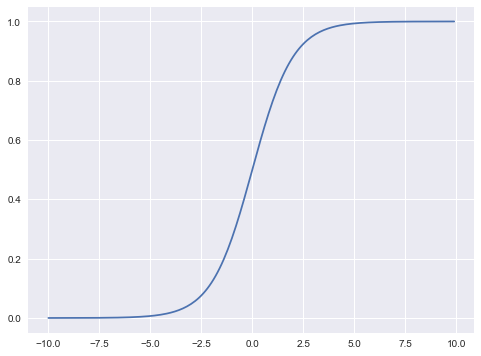

In [143]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(-10,10,step=0.1),sigmoid(np.arange(-10,10,step=0.1)))
plt.show

# 逻辑回归的代价函数
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$

In [144]:
def cost(theta,X,y):
    inner1 = -np.multiply(y,np.log(sigmoid(X@theta)))
    inner2 = -np.multiply(1-y,np.log(1-sigmoid(X@theta)))
    return np.mean(inner1+inner2)
    #return np.sum(inner1+inner2,axis=0)/X.shape[0]

In [145]:
cost(theta,X,y)

0.6931471805599453

# 梯度下降
* 这是批量梯度下降（batch gradient descent）  
* **转化为向量化计算：** $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [146]:
def gradient(theta,X,y):
    return (1/len(X))* X.T @ (sigmoid(X@theta) - y)

In [147]:
gradient(theta,X,y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数 
> * 这里我们使用scipy.optimize.minimize去寻找参数

In [148]:
import scipy.optimize as opt

In [149]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

In [150]:
print(res)

     fun: 0.20349770451259855
     jac: array([1.62947970e-05, 1.11339134e-03, 1.07609314e-03])
 message: 'Optimization terminated successfully.'
    nfev: 71
    nhev: 0
     nit: 28
    njev: 242
  status: 0
 success: True
       x: array([-25.16576744,   0.20626712,   0.20150754])


# 对拟合结果进行验证

In [151]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [152]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       0.87      0.85      0.86        40
        1.0       0.90      0.92      0.91        60

avg / total       0.89      0.89      0.89       100



# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [154]:
print(res.x) # this is final theta 这表示一条直线 分别求出其斜率以及截距即可绘图

[-25.16576744   0.20626712   0.20150754]


In [155]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[124.88747248  -1.02361985  -1.        ]


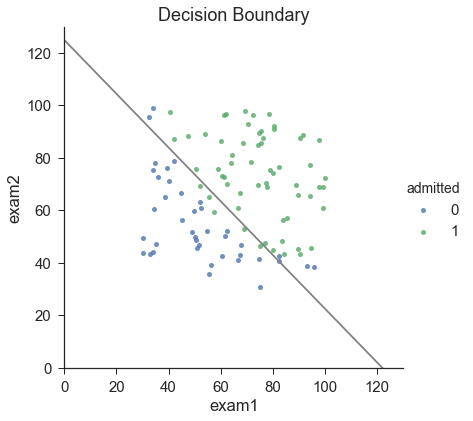

In [156]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

# 正则化逻辑回归

In [157]:
df = pd.read_csv("ex2data2.txt",names=["test1","test2","accepted"])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


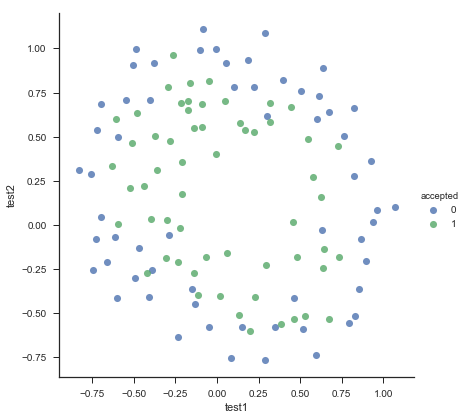

In [158]:
sns.set(context='notebook',style='ticks')
sns.lmplot('test1','test2',data=df,hue='accepted',size=6,fit_reg=False,scatter_kws={"s":50})
plt.show()

**特征映射**

从上图可以看出，无法用直线进行拟合，这里我们将特征进行高阶映射，从而实现非线性拟合的效果

In [162]:
degree = 5
x1 = df['test1']
x2 = df['test2']

df.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        df['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

df.drop('test1', axis=1, inplace=True)
df.drop('test2', axis=1, inplace=True)

df.head()

,accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


# 正则化代价函数
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [171]:
def regularized_cost(theta, X, y, l=1):
    thetaOneToN = theta[1:]
    reg_term = (l/(2*X.shape[0]))* np.power(thetaOneToN,2).sum()
    return cost(theta,X,y)+reg_term

In [177]:
npdata = np.array(df)
X = npdata[:,1:]
y = npdata[:,0]
theta = np.zeros(X.shape[1])
X.shape,y.shape,theta.shape

((118, 11), (118,), (11,))

In [178]:
regularized_cost(theta,X,y,1)

0.6931471805599454

# 正则化代价函数的梯度计算

请注意等式中的"reg" 项。还注意到另外的一个“学习率”参数。这是一种超参数，用来控制正则化项。现在我们需要添加正则化梯度函数：
如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

In [179]:
def regularized_gradient(theta,X,y,l=1):
    thetaOneToN = theta[1:]
    regThea = (l/X.shape[0])*thetaOneToN
    
    regTerm = np.concatenate([np.array([0]),regThea])
    
    return gradient(theta,X,y)+regTerm

In [180]:
regularized_gradient(theta, X, y)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

# 拟合参数


In [181]:
import scipy.optimize as opt
res = opt.minimize(fun=regularized_cost,x0=theta,args=(X,y),method="Newton-CG",jac=regularized_gradient)
res

     fun: 0.6226824388265478
     jac: array([-8.84282275e-09, -1.36031504e-08, -2.53424702e-08,  2.45716402e-08,
        7.90325321e-09, -5.82386790e-09, -1.83127827e-08,  2.13735031e-08,
        4.56851222e-09,  9.69293636e-09, -2.88007942e-09])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 56
  status: 0
 success: True
       x: array([ 0.53010058,  0.29074988, -1.60725151, -0.5821357 ,  0.01781226,
       -0.21329678, -0.40024121, -1.37144994,  0.02264094, -0.95034236,
        0.03440901])

# 预测结果


In [182]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       0.71      0.57      0.63        60
        1.0       0.63      0.76      0.69        58

avg / total       0.67      0.66      0.66       118

